# Stage bias SNR analysis
---

In [1]:
from pathlib import Path
import re
import random
from functools import partial

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

from skimage import img_as_float, dtype_limits
from skimage.io import imread
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_otsu

## SNR measurement
---

\begin{equation}
R_n = \frac{\text{cov}(I_1, I_2)}{\sqrt{\text{var}(I_1)\text{var}(I_2)}}
\end{equation}

\begin{equation}
SNR = \frac{R_n}{1 - R_n}
\end{equation}

#### References
> Joy, David C. "Noise and its effects on the low-voltage SEM." *Biological Low-Voltage Scanning Electron Microscopy*, pp. 129-144. Springer, New York, NY, 2008.

In [2]:
def clip_intensity(image, pct=0):
    """Clips intensity by given percentage"""
    p1, p2 = np.percentile(image, (pct, 100-pct))
    imrs = rescale_intensity(image, in_range=(p1, p2))
    return imrs

In [3]:
def calc_SNR(image, clip=None):
    """Compute signal to noise ratio of image
    
    Parameters
    ----------
    image : array
        Input image
    
    clip : None or float, optional
        Percentage by which to clip intensity range
        No clipping is done by default
    
    Returns
    -------
    SNR : float
        Computed signal to noise ratio
    """
    # Convert image to float
    image = img_as_float(image)
    
    # Optionally clip intensity
    if clip is not None:
        image = clip_intensity(image, pct=clip)
    
    # Separate even and odd rows
    even = image[::2, :]
    oddd = image[1::2, :]
    
    # Compute SNR
    cov = np.mean((even.T - even.mean(axis=1)) *\
                  (oddd.T - oddd.mean(axis=1)), axis=0)
    var = np.sqrt(np.var(even, ddof=1, axis=1) *\
                  np.var(oddd, ddof=1, axis=1))
    Rn = cov / var
    snr = Rn / (1 - Rn)
    return snr.mean()

## Measure SNR
---
### Generate data and process images

In [4]:
# Collect images
# --------------
fp_dir = Path('../data/SNR_images/')
fps = list(fp_dir.glob('**/*.tif'))

# Process images
# --------------
columns = ['MODE', 'LE', 'SB', 'PE', 'HFW', 'PS', 'DWELL', 'SNR', 'FP']
df_out = pd.DataFrame(columns=columns)

for i, fp in tqdm(enumerate(fps), total=len(fps)):

    # Parse filepath for settings
    fp_mode = fp.parents[2].name
    fp_energy = fp.parents[1].name
    fp_pixels = fp.stem

    # String to values
    mode = fp_mode.split('-')[0]
    energies = [float(i) for i in re.findall(r'\d+', fp_energy)]
    pixels = [float(i) for i in re.findall(r'\d+', fp_pixels)]

    # Compute SNR & CNR
    image = imread(fp)
    snr = calc_SNR(image, clip=0.1)

    # Build up DataFrame
    df_out.loc[i, 'MODE'] = mode
    df_out.loc[i, 'LE'] = energies[0]
    df_out.loc[i, 'SB'] = energies[1]
    df_out.loc[i, 'PE'] = energies[0] + energies[1]
    df_out.loc[i, 'HFW'] = pixels[0]
    df_out.loc[i, 'PS'] = pixels[0] / image.shape[1]
    df_out.loc[i, 'DWELL'] = pixels[1]
    df_out.loc[i, 'SNR'] = snr
    df_out.loc[i, 'FP'] = fp

# Preview
df_out = df_out.infer_objects()
df_out.sample(5)

MODE      LE      SB      PE  HFW        PS  DWELL       SNR  \
304  UHR  1500.0  2000.0  3500.0  4.0  0.001953    5.0  5.881066   
142   HR  1500.0   200.0  1700.0  4.0  0.001953   20.0  1.397900   
1     HR  1500.0     0.0  1500.0  4.0  0.001953    1.0 -0.083242   
382  UHR  1500.0   500.0  2000.0  4.0  0.001953   20.0  0.754466   
380  UHR  1500.0   500.0  2000.0  4.0  0.001953   10.0  0.331828   

                                                    FP  
304  ..\data\SNR_images\UHR-mode\1500eV-LE__2000V-S...  
142  ..\data\SNR_images\HR-mode\1500eV-LE__200V-SB\...  
1    ..\data\SNR_images\HR-mode\1500eV-LE__0V-SB\fi...  
382  ..\data\SNR_images\UHR-mode\1500eV-LE__500V-SB...  
380  ..\data\SNR_images\UHR-mode\1500eV-LE__500V-SB...

### Sample image

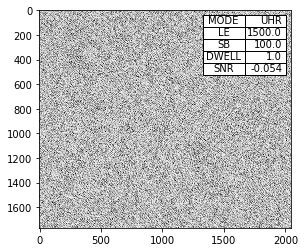

In [5]:
# Choose random sample
rs = df_out.sample(1)
image = clip_intensity(imread(rs['FP'].values[0]))

# Plot random sample
fig, ax = plt.subplots()
ax.imshow(image, cmap='Greys_r')

# Make table
vals = rs.drop(columns=['FP', 'PS', 'PE', 'HFW']).round({'SNR': 3}).T.values
cols = rs.drop(columns=['FP', 'PS', 'PE', 'HFW']).columns.tolist()
tab = ax.table(cellText=vals, rowLabels=cols,
               rowLoc='center', loc='upper right',
               zorder=1)
tab.auto_set_column_width(0)

## Analysis
---

### Dependence on stage bias

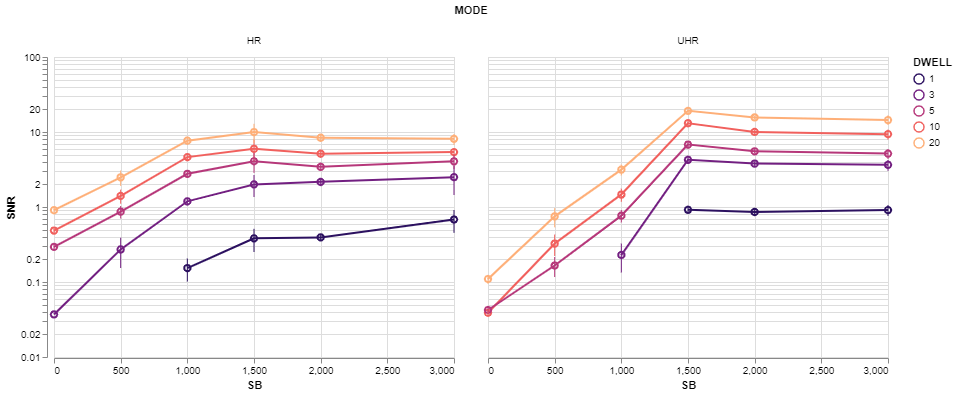

In [6]:
source = df_out.loc[(df_out['SNR'] > 0.02) &\
                    (~df_out['SB'].isin([100, 200]))].drop('FP', axis=1).copy()
scheme = 'magma'

chart = alt.Chart().encode(
    x=alt.X('SB:Q',
            axis=alt.Axis(tickMinStep=500)),
    y=alt.Y('SNR:Q',
            aggregate='mean',
            scale=alt.Scale(type='log')),
    color=alt.Color('DWELL:N',
                    scale=alt.Scale(scheme=scheme))
)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart(source).mark_errorbar(extent='stdev').encode(
    x=alt.X('SB:Q'),
    y=alt.Y('SNR:Q'),
    color=alt.Color('DWELL:N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).facet(
    column='MODE:N'
)

### Dependence on dwell

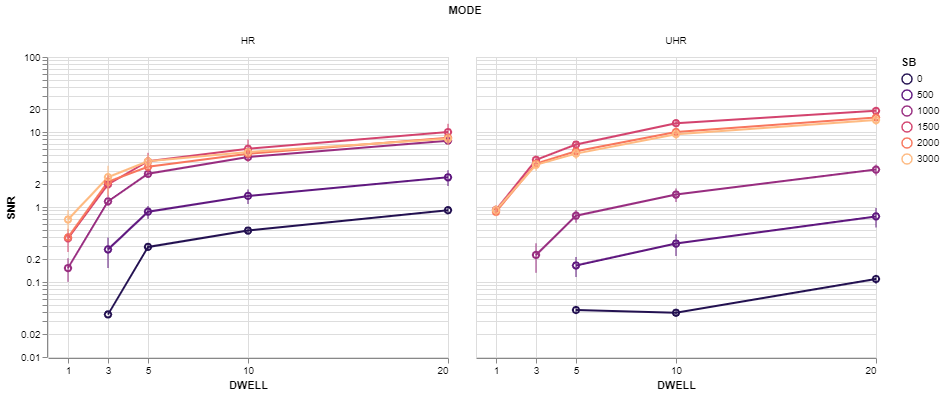

In [7]:
source = df_out.loc[(df_out['SNR'] > 0.02) &\
                    (~df_out['SB'].isin([100, 200]))].drop('FP', axis=1).copy()
scheme = 'magma'

chart = alt.Chart().encode(
    x=alt.X('DWELL:Q',
            axis=alt.Axis(values=np.sort(source['DWELL'].unique()).tolist())),
    y=alt.Y('SNR:Q',
            aggregate='mean',
            scale=alt.Scale(type='log')),
    color=alt.Color('SB:N',
                    scale=alt.Scale(scheme=scheme))
)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart(source).mark_errorbar(extent='stdev').encode(
    x=alt.X('DWELL:Q'),
    y=alt.Y('SNR:Q'),
    color=alt.Color('SB:N',
                    scale=alt.Scale(scheme=scheme))
)

alt.layer(chart, error_bars, data=source).facet(
    column='MODE:N'
)

### HR vs UHR mode

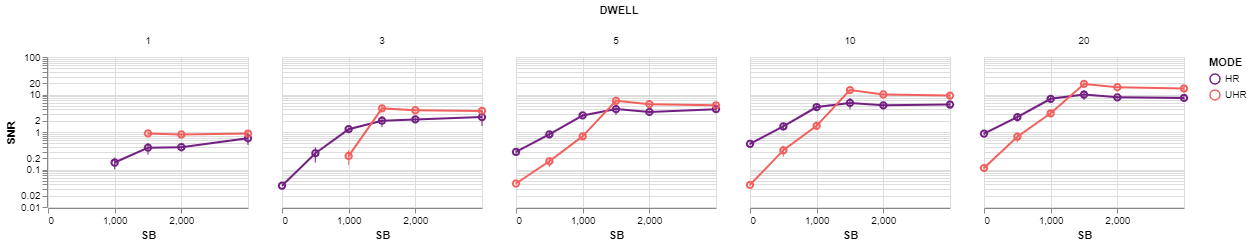

In [8]:
source = df_out.loc[(df_out['SNR'] > 0.02) &\
                    (~df_out['SB'].isin([100, 200]))].drop('FP', axis=1).copy()
scheme = 'magma'

chart = alt.Chart().encode(
    x=alt.X('SB:Q',
            axis=alt.Axis(values=np.sort(source['SB'].unique()).tolist())),
    y=alt.Y('SNR:Q',
            aggregate='mean',
            scale=alt.Scale(type='log')),
    color=alt.Color('MODE:N',
                    scale=alt.Scale(scheme=scheme))
).properties(
    width=200,
    height=150,
)

chart = (chart.mark_line() +\
         chart.mark_point(size=40))

error_bars = alt.Chart(source).mark_errorbar(extent='stdev').encode(
    x=alt.X('SB:Q'),
    y=alt.Y('SNR:Q'),
    color=alt.Color('MODE:N')
)

alt.layer(chart, error_bars, data=source).facet(
    column='DWELL:N'
)

## Image matrices
---
### Stage bias vs dwell | HR-mode

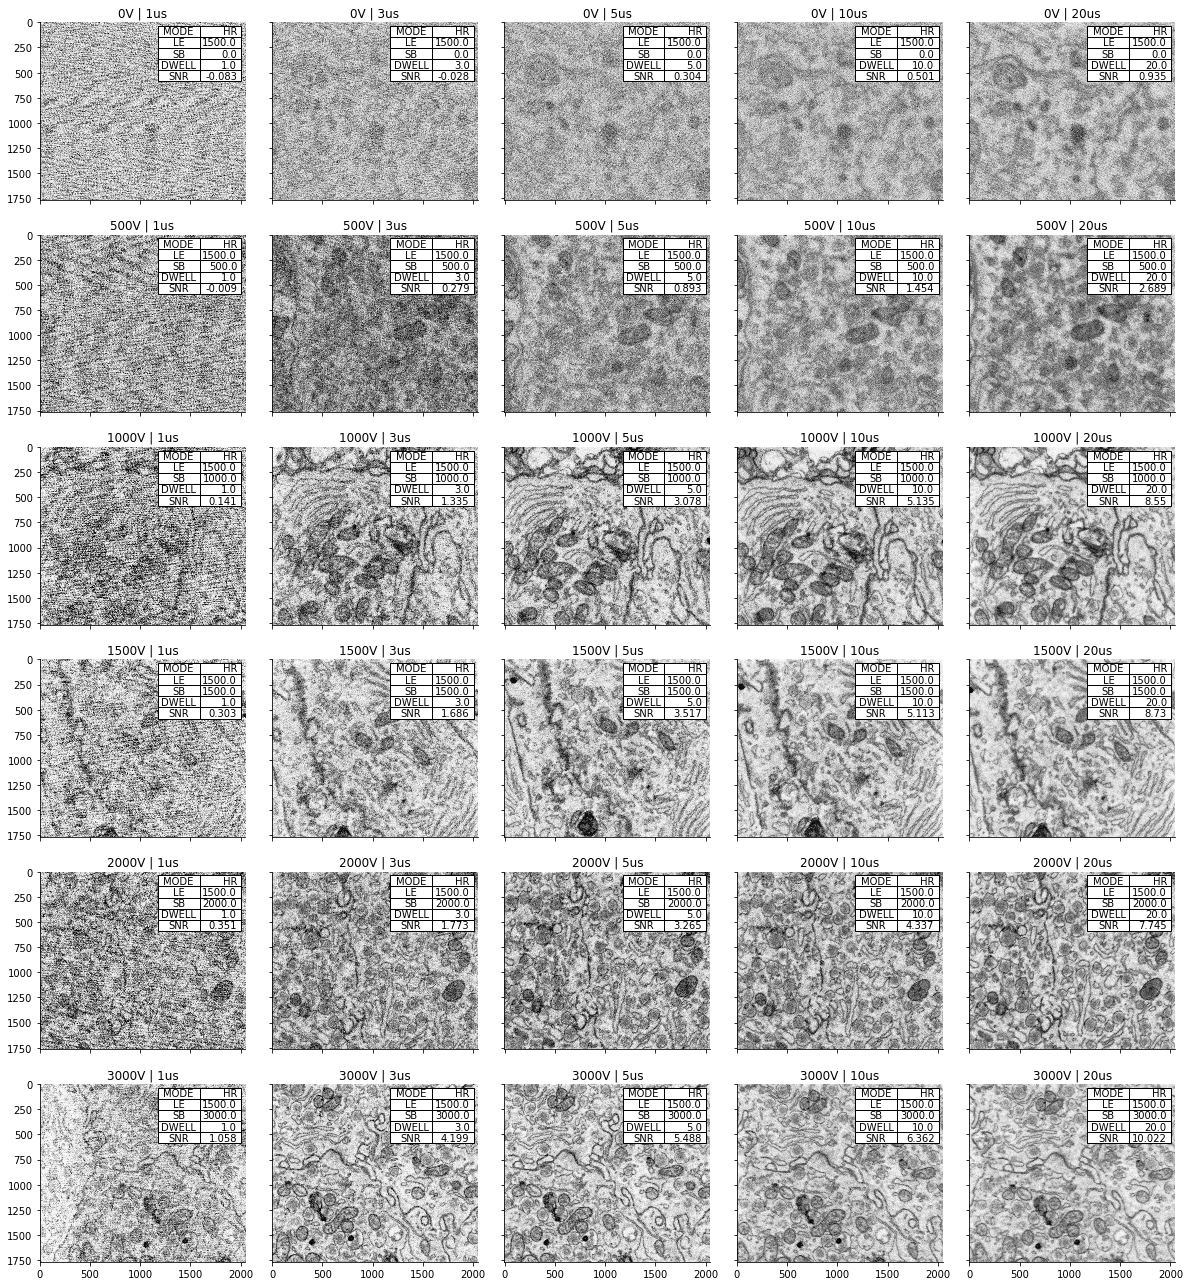

In [9]:
# Filter dataset
mode = 'HR'
source = df_out.loc[(df_out['MODE'] == mode) &\
                    (~df_out['SB'].isin([100, 200]))]\
               .groupby(['SB', 'DWELL'])\
               .apply(lambda x: x.iloc[0])\
               .reset_index(drop=True)

# FacetGrid
g = sns.FacetGrid(source, row='SB', col='DWELL', aspect=1.1)
# Plot images onto grid
for i, ((SB, DWELL), grp) in enumerate(source.groupby(['SB', 'DWELL'])):
    ax = g.axes.flat[i]
    image = clip_intensity(imread(grp['FP'].iloc[0]))
    ax.imshow(image, cmap='Greys_r')
    ax.set_title(f"{SB:.0f}V | {DWELL:.0f}us")
    # Make table
    vals = grp.drop(columns=['FP', 'PS', 'PE', 'HFW']).round({'SNR': 3}).T.values
    cols = grp.drop(columns=['FP', 'PS', 'PE', 'HFW']).columns.tolist()
    tab = ax.table(cellText=vals, rowLabels=cols,
                   rowLoc='center', loc='upper right', zorder=1)
    tab.auto_set_column_width(0)

### Stage bias vs dwell | UHR-mode

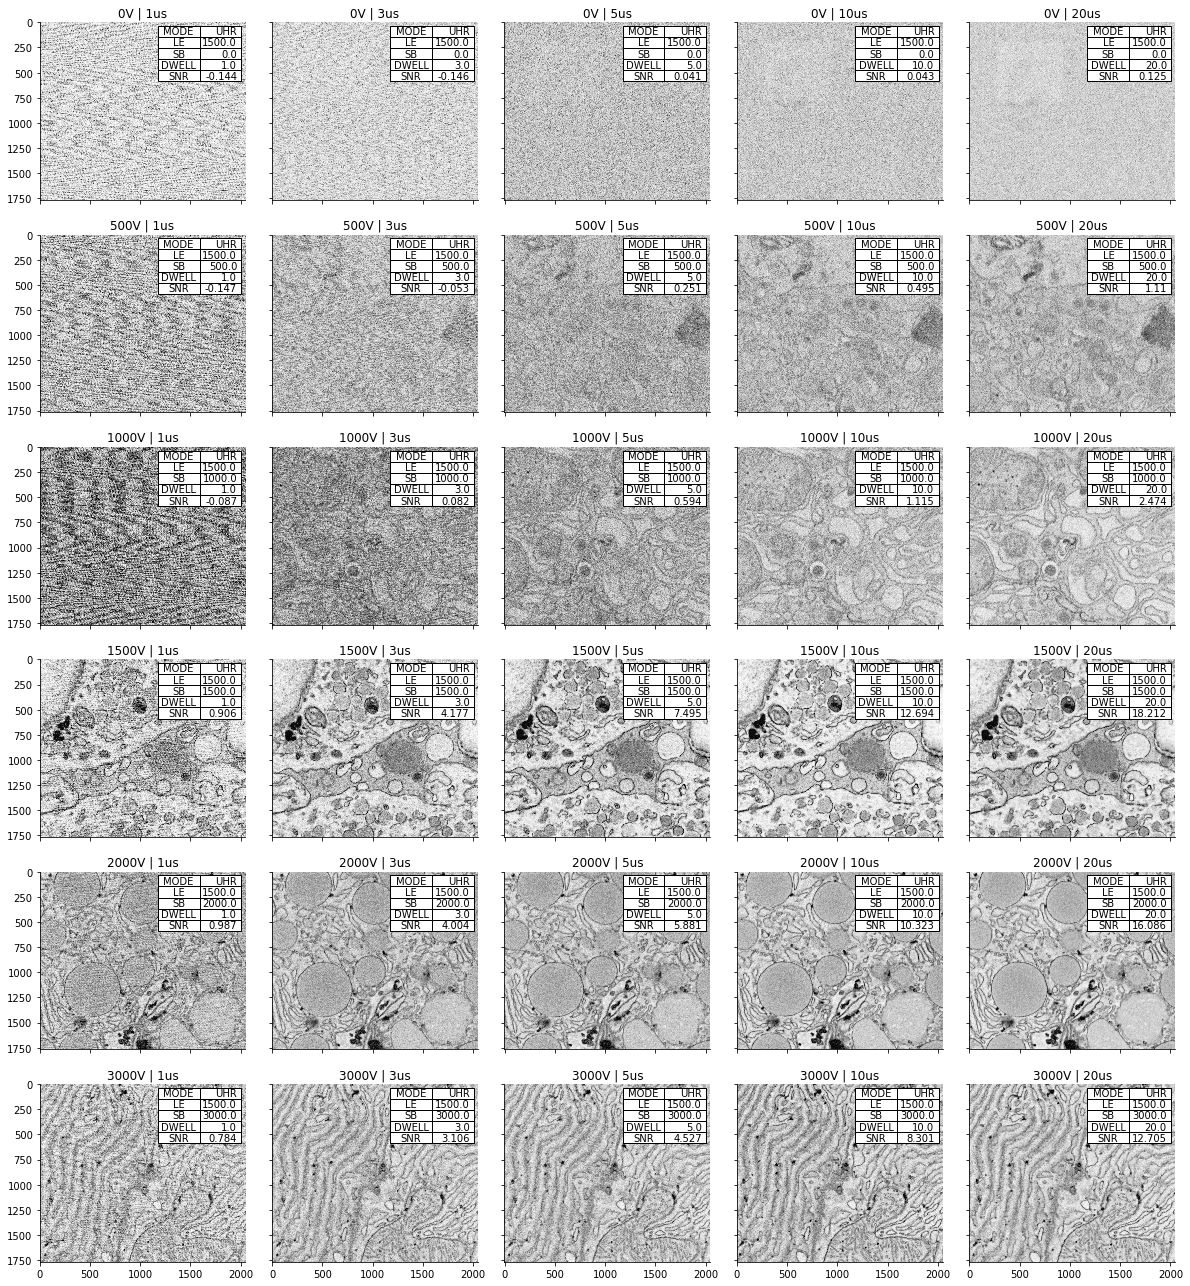

In [10]:
# Filter dataset
mode = 'UHR'
source = df_out.loc[(df_out['MODE'] == mode) &\
                    (~df_out['SB'].isin([100, 200]))]\
               .groupby(['SB', 'DWELL'])\
               .apply(lambda x: x.iloc[0])\
               .reset_index(drop=True)

# FacetGrid
g = sns.FacetGrid(source, row='SB', col='DWELL', aspect=1.1)
# Plot images onto grid
for i, ((SB, DWELL), grp) in enumerate(source.groupby(['SB', 'DWELL'])):
    ax = g.axes.flat[i]
    image = clip_intensity(imread(grp['FP'].iloc[0]))
    ax.imshow(image, cmap='Greys_r')
    ax.set_title(f"{SB:.0f}V | {DWELL:.0f}us")
    # Make table
    vals = grp.drop(columns=['FP', 'PS', 'PE', 'HFW']).round({'SNR': 3}).T.values
    cols = grp.drop(columns=['FP', 'PS', 'PE', 'HFW']).columns.tolist()
    tab = ax.table(cellText=vals, rowLabels=cols,
                   rowLoc='center', loc='upper right', zorder=1)
    tab.auto_set_column_width(0)

### HR vs UHR mode | Fixed dwell

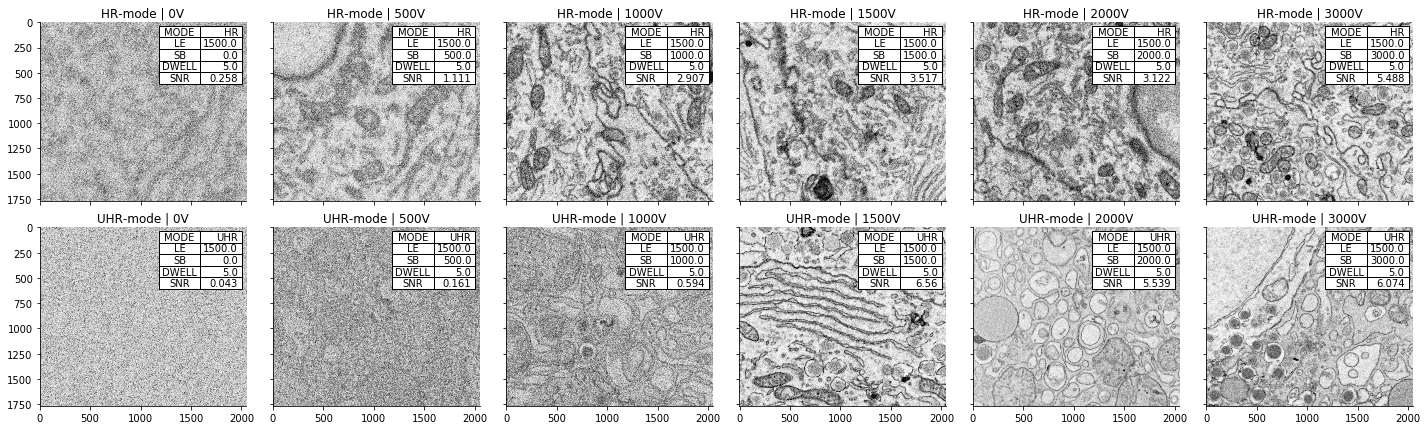

In [11]:
# Filter dataset
DWELL = 5
source = df_out.loc[(df_out['DWELL'] == DWELL) &      \
                    (~df_out['SB'].isin([100, 200]))] \
               .groupby(['MODE', 'SB'])               \
               .apply(lambda x: x.sample(1))          \
               .reset_index(drop=True)

# FacetGrid
g = sns.FacetGrid(source, row='MODE', col='SB', aspect=1.1)
# Plot images onto grid
for i, ((MODE, SB), grp) in enumerate(source.groupby(['MODE', 'SB'])):
    ax = g.axes.flat[i]
    image = clip_intensity(imread(grp['FP'].iloc[0]))
    ax.imshow(image, cmap='Greys_r')
    ax.set_title(f"{MODE}-mode | {SB:.0f}V")
    # Make table
    vals = grp.drop(columns=['FP', 'PS', 'PE', 'HFW']).round({'SNR': 3}).T.values
    cols = grp.drop(columns=['FP', 'PS', 'PE', 'HFW']).columns.tolist()
    tab = ax.table(cellText=vals, rowLabels=cols,
                   rowLoc='center', loc='upper right', zorder=1)
    tab.auto_set_column_width(0)